In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.9
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 701ms/step - loss: 0.0099
Average validation loss: 0.694392204284668
4/4 [==============================] - 7s 715ms/step - loss: 0.0099 - val_loss: 0.6944
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 10s 800ms/step - loss: 0.0072 - val_loss: 0.6944
Average validation loss: 0.7147380113601685
4/4 [==============================] - 10s 816ms/step - loss: 0.0072 - val_loss: 0.7046
Epoch 3/10
4/4 [==============================] - 14s 812ms/step - loss: 0.0056 - val_loss: 0.7046
Average validation loss: 0.6732792854309082
4/4 [==============================] - 14s 826ms/step - loss: 0.0056 - val_loss: 0.6941
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_siz

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 729ms/step - loss: 4.3236e-04
Average validation loss: 0.4312942773103714
8/8 [==============================] - 6s 743ms/step - loss: 4.3236e-04 - val_loss: 0.4313
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 758ms/step - loss: 4.2477e-04 - val_loss: 0.4313
Average validation loss: 0.49072055518627167
8/8 [==============================] - 12s 769ms/step - loss: 4.2477e-04 - val_loss: 0.4610
Epoch 3/10
8/8 [==============================] - 18s 709ms/step - loss: 4.1393e-04 - val_loss: 0.4610
Average validation loss: 0.46199755370616913
8/8 [==============================] - 18s 726ms/step - loss: 4.1393e-04 - val_loss: 0.4613
Epoch 4/10
8/8 [==============================] - 24s 699ms/step - loss: 4.0322e-04 - val_loss: 0.4613
Average validation loss: 0.0053684

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 746ms/step - loss: 4.9159e-04
Average validation loss: 0.039661941843708824
12/12 [==============================] - 9s 760ms/step - loss: 4.9159e-04 - val_loss: 0.0397
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 710ms/step - loss: 5.0330e-04 - val_loss: 0.0397
Average validation loss: 0.0486046756000178
12/12 [==============================] - 18s 722ms/step - loss: 5.0330e-04 - val_loss: 0.0441
Epoch 3/10
12/12 [==============================] - 27s 749ms/step - loss: 4.9828e-04 - val_loss: 0.0441
Average validation loss: 0.028174620238132775
12/12 [==============================] - 27s 759ms/step - loss: 4.9828e-04 - val_loss: 0.0388
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weigh

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 730ms/step - loss: 4.2053e-04
Average validation loss: 0.0313458819873631
16/16 [==============================] - 12s 745ms/step - loss: 4.2053e-04 - val_loss: 0.0313
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 722ms/step - loss: 4.1691e-04 - val_loss: 0.0313
Average validation loss: 0.039060021517798305
16/16 [==============================] - 24s 737ms/step - loss: 4.1691e-04 - val_loss: 0.0352
Epoch 3/10
16/16 [==============================] - 35s 716ms/step - loss: 4.1222e-04 - val_loss: 0.0352
Average validation loss: 0.04982842160825385
16/16 [==============================] - 35s 728ms/step - loss: 4.1222e-04 - val_loss: 0.0401
Epoch 4/10
16/16 [==============================] - 47s 707ms/step - loss: 4.0947e-04 - val_loss: 0.0401
Average validatio

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 727ms/step - loss: 2.9287e-04
Average validation loss: 0.15370642095804216
20/20 [==============================] - 15s 739ms/step - loss: 2.9287e-04 - val_loss: 0.1537
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 707ms/step - loss: 2.7403e-04 - val_loss: 0.1537
Average validation loss: 0.586395400762558
20/20 [==============================] - 29s 719ms/step - loss: 2.7403e-04 - val_loss: 0.3701
Epoch 3/10
20/20 [==============================] - 44s 730ms/step - loss: 2.6079e-04 - val_loss: 0.3701
Average validation loss: 0.2701429516077042
20/20 [==============================] - 44s 745ms/step - loss: 2.6079e-04 - val_loss: 0.3367
Epoch 4/10
20/20 [==============================] - 58s 719ms/step - loss: 2.5530e-04 - val_loss: 0.3367
Average validation l

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 718ms/step - loss: 2.5206e-04
Average validation loss: 0.07867167517542839
24/24 [==============================] - 18s 730ms/step - loss: 2.5206e-04 - val_loss: 0.0787
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 712ms/step - loss: 2.4783e-04 - val_loss: 0.0787
Average validation loss: 0.15227365245421728
24/24 [==============================] - 35s 723ms/step - loss: 2.4783e-04 - val_loss: 0.1155
Epoch 3/10
24/24 [==============================] - 52s 710ms/step - loss: 2.3327e-04 - val_loss: 0.1155
Average validation loss: 0.10158372297883034
24/24 [==============================] - 52s 721ms/step - loss: 2.3327e-04 - val_loss: 0.1108
Epoch 4/10
24/24 [==============================] - 69s 709ms/step - loss: 2.2041e-04 - val_loss: 0.1108
Average validatio

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 712ms/step - loss: 3.1192e-04
Average validation loss: 0.07296840846538544
40/40 [==============================] - 29s 725ms/step - loss: 3.1192e-04 - val_loss: 0.0730
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 57s 708ms/step - loss: 2.8499e-04 - val_loss: 0.0730
Average validation loss: 0.11949084214866161
40/40 [==============================] - 58s 720ms/step - loss: 2.8499e-04 - val_loss: 0.0962
Epoch 3/10
40/40 [==============================] - 86s 707ms/step - loss: 2.6554e-04 - val_loss: 0.0962
Average validation loss: 0.08657450191676616
40/40 [==============================] - 87s 720ms/step - loss: 2.6554e-04 - val_loss: 0.0930
Epoch 4/10
40/40 [==============================] - 116s 721ms/step - loss: 2.4860e-04 - val_loss: 0.0930
Average validati

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 723ms/step - loss: 2.2989e-04
Average validation loss: 0.41299286613987835
48/48 [==============================] - 35s 735ms/step - loss: 2.2989e-04 - val_loss: 0.4130
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 718ms/step - loss: 2.2160e-04 - val_loss: 0.4130
Average validation loss: 0.08423068426175935
48/48 [==============================] - 70s 729ms/step - loss: 2.2160e-04 - val_loss: 0.2486
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 105s 712ms/step - loss: 1.9579e-04 - val_loss: 0.2486
Average validation loss: 0.10002367864944972
48/48 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 721ms/step - loss: 2.4007e-04
Average validation loss: 0.11050351858596384
56/56 [==============================] - 41s 732ms/step - loss: 2.4007e-04 - val_loss: 0.1105
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 711ms/step - loss: 2.0000e-04 - val_loss: 0.1105
Average validation loss: 0.08259017454221455
56/56 [==============================] - 82s 723ms/step - loss: 2.0000e-04 - val_loss: 0.0965
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 122s 717ms/step - loss: 1.8057e-04 - val_loss: 0.0965
Average validation loss: 0.07629535178687417
56/56 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 719ms/step - loss: 1.5793e-04
Average validation loss: 0.09342362846905417
64/64 [==============================] - 47s 730ms/step - loss: 1.5793e-04 - val_loss: 0.0934
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 716ms/step - loss: 1.3345e-04 - val_loss: 0.0934
Average validation loss: 0.10245388282413614
64/64 [==============================] - 93s 728ms/step - loss: 1.3345e-04 - val_loss: 0.0979
Epoch 3/10
64/64 [==============================] - 139s 711ms/step - loss: 1.2314e-04 - val_loss: 0.0979
Average validation loss: 0.06714600734991549
64/64 [==============================] - 140s 723ms/step - loss: 1.2314e-04 - val_loss: 0.0877
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/we

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 717ms/step - loss: 1.7431e-04
Average validation loss: 0.09671843807316488
72/72 [==============================] - 52s 728ms/step - loss: 1.7431e-04 - val_loss: 0.0967
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 715ms/step - loss: 1.4817e-04 - val_loss: 0.0967
Average validation loss: 0.09118864499032497
72/72 [==============================] - 105s 726ms/step - loss: 1.4817e-04 - val_loss: 0.0940
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 157s 724ms/step - loss: 1.3531e-04 - val_loss: 0.0940
Average validation loss: 0.07319779093894693
72/72 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 725ms/step - loss: 1.4251e-04
Average validation loss: 0.11023216471076011
80/80 [==============================] - 59s 736ms/step - loss: 1.4251e-04 - val_loss: 0.1102
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 117s 718ms/step - loss: 1.1843e-04 - val_loss: 0.1102
Average validation loss: 0.09810117296874524
80/80 [==============================] - 117s 730ms/step - loss: 1.1843e-04 - val_loss: 0.1042
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 175s 714ms/step - loss: 1.0674e-04 - val_loss: 0.1042
Average validation loss: 0.06793900355696678
80/80 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 717ms/step - loss: 2.4351e-04
Average validation loss: 0.21188735009170698
96/96 [==============================] - 70s 729ms/step - loss: 2.4351e-04 - val_loss: 0.2119
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 717ms/step - loss: 1.8263e-04 - val_loss: 0.2119
Average validation loss: 0.10140418478724438
96/96 [==============================] - 140s 728ms/step - loss: 1.8263e-04 - val_loss: 0.1566
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 209s 715ms/step - loss: 1.5643e-04 - val_loss: 0.1566
Average validation loss: 0.14411447770321098
96/96 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 720ms/step - loss: 1.7494e-04
Average validation loss: 0.15272292591274284
120/120 [==============================] - 88s 731ms/step - loss: 1.7494e-04 - val_loss: 0.1527
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 716ms/step - loss: 1.5212e-04 - val_loss: 0.1527
Average validation loss: 0.06820947490167932
120/120 [==============================] - 175s 728ms/step - loss: 1.5212e-04 - val_loss: 0.1105
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 262s 721ms/step - loss: 1.3544e-04 - val_loss: 0.1105
Average validation loss: 0.12067466737977763
120/120 [================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 104s 721ms/step - loss: 1.4919e-04
Average validation loss: 0.08069779643359196
144/144 [==============================] - 106s 733ms/step - loss: 1.4919e-04 - val_loss: 0.0807
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 210s 721ms/step - loss: 1.2417e-04 - val_loss: 0.0807
Average validation loss: 0.13832578394163952
144/144 [==============================] - 211s 733ms/step - loss: 1.2417e-04 - val_loss: 0.1095
Epoch 3/10
144/144 [==============================] - 315s 720ms/step - loss: 1.1588e-04 - val_loss: 0.1095
Average validation loss: 0.048799368521385764
144/144 [==============================] - 316s 731ms/step - loss: 1.1588e-04 - val_loss: 0.0893
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 717ms/step - loss: 1.4021e-04
Average validation loss: 0.21841288060386432
160/160 [==============================] - 117s 728ms/step - loss: 1.4021e-04 - val_loss: 0.2184
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 716ms/step - loss: 1.1764e-04 - val_loss: 0.2184
Average validation loss: 0.15522679595742375
160/160 [==============================] - 233s 727ms/step - loss: 1.1764e-04 - val_loss: 0.1868
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 348s 717ms/step - loss: 1.0447e-04 - val_loss: 0.1868
Average validation loss: 0.09874818612588569
160/160 [==============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 717ms/step - loss: 1.9889e-04
Average validation loss: 0.06371730666333608
200/200 [==============================] - 146s 729ms/step - loss: 1.9889e-04 - val_loss: 0.0637
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 289s 716ms/step - loss: 1.5915e-04 - val_loss: 0.0637
Average validation loss: 0.0649168844519545
200/200 [==============================] - 291s 728ms/step - loss: 1.5915e-04 - val_loss: 0.0643
Epoch 3/10
200/200 [==============================] - 434s 716ms/step - loss: 1.3984e-04 - val_loss: 0.0643
Average validation loss: 0.12809230466409643
200/200 [==============================] - 437s 727ms/step - loss: 1.3984e-04 - val_loss: 0.0856
Epoch 4/10
200/200 [==============================] - 580s 717ms/step - loss: 1.3011e-04 - val_loss: 0.0

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:55 - loss: 9.6184e-05

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 171s 714ms/step - loss: 1.5384e-04
Average validation loss: 0.05906954418866614
240/240 [==============================] - 174s 726ms/step - loss: 1.5384e-04 - val_loss: 0.0591
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 345s 713ms/step - loss: 1.2782e-04 - val_loss: 0.0591
Average validation loss: 0.07727707905966479
240/240 [==============================] - 348s 724ms/step - loss: 1.2782e-04 - val_loss: 0.0682
Epoch 3/10
240/240 [==============================] - 520s 715ms/step - loss: 1.1305e-04 - val_loss: 0.0682
Average validation loss: 0.06324082973984939
240/240 [==============================] - 523s 727ms/step - loss: 1.1305e-04 - val_loss: 0.0665
Epoch 4/10
240/240 [==============================] - 695s 718ms/step - loss: 1.0254e-04 - val_loss: 0.

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.13314780665764375, 0.08503760486973533, 0.06210439520881057, 0.16187813134936732, 0.2444162677608547, 0.09836695084760018, 0.09784511008633762, 0.09535620073553369, 0.09724422688597575, 0.08124581810802084, 0.06663506479503785, 0.06537186483474428, 0.07608226507432286, 0.06945743704961597, 0.07447439940015413, 0.0760432907902958, 0.06808557641986819, 0.06842347009920614]
std_val_losses =  [0.21651041361901363, 0.10519570582241945, 0.03912050278440206, 0.19692423349235882, 0.25211119036272645, 0.0375741067755267, 0.028462933367654705, 0.0540270079766367, 0.046144442900279935, 0.040761669906019475, 0.027652386704521345, 0.028950417334801335, 0.03680751193603845, 0.035794778927118, 0.04117758432476698, 0.04575931064636978, 0.03268569242774432, 0.03610597307000737]


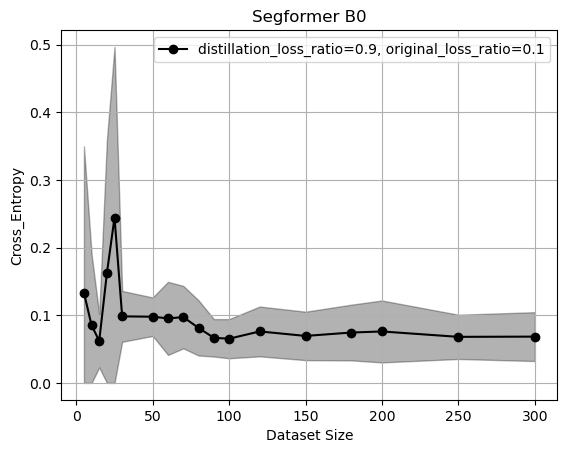

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()